# Hexokinase (HEX1)
To construct the hexokinase module, first we import <b>masspy</b> and other essential packages. Constants used throughout the notebook are also defined.

In [1]:
from os import path

import matplotlib.pyplot as plt

from scipy import optimize

import sympy as sym

from cobra import DictList

from mass.analysis.linear import matrix_rank
from mass import MassMetabolite, Simulation, UnitDefinition, qcqa_model
from mass.enzyme_modules import EnzymeModule
from mass.io import json, sbml
from mass.util import Keq2k, k2Keq, strip_time

Note that the total enzyme concentration of HEX1 is \\(24 nM = 0.024 \mu M = 0.000024 mM\\).

For the construction of the <font color=#4682B4>EnzymeModule</font> for HEX1, the following assumptions were made:

1. The enzyme is a monomer.
2. The enzyme binding and catalyzation of substrates occurs in an random sequential mechanism.
3. The enzyme experiences product inhibtion, and is competitively inhibited by 23DPG when complexed with D-glucose.

## Module Construction
The first step of creating the HEX1 module is to define the <font color=#4682B4>EnzymeModule</font>. The <font color=#4682B4>EnzymeModule</font> is an extension of the <font color=#4682B4>MassModel</font>, with additional enzyme-specific attributes that aid in the construction, validation, and utilization of the module.

__Note:__ All <font color=#4682B4>EnzymeModule</font> specific attributes start will start the prefix "enzyme" or "enzyme_module".

In [2]:
HEX1 = EnzymeModule("HEX1", name="Hexokinase (D-glucose:ATP)", subsystem="Glycolysis")

### Metabolites
#### Ligands
The next step is to define all of the metabolites using the <font color=#4682B4>MassMetabolite</font> object. For <font color=#4682B4>EnzymeModules</font>, the <font color=#4682B4>MassMetabolite</font> objects will be refered to as ligands, for these <font color=#4682B4>MassMetabolite</font> form a complex with the enzyme to serve some biological purpose. Some considerations for this step include the following:

1. It is important to use a clear and consistent format for identifiers and names when defining the <font color=#4682B4>MassMetabolite</font> objects for various reasons, some of which include improvements to model clarity and utility, assurance of unique identifiers (required to add metabolites to the model), and consistency when collaborating and communicating with others. 


2. In order to ensure our model is physiologically accurate, it is important to provide the <font color=#B22222>formula</font> argument with a string representing the chemical formula for each metabolite, and the <font color=#B22222>charge</font> argument with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). These attributes can always be set later if necessary using the <font color=#1E90FF>formula</font> and <font color=#1E90FF>charge</font> attribute setter methods.


3. To indicate that the cytosol is the cellular compartment in which the reactions occur, the string "c" is provided to the <font color=#B22222>compartment</font> argument.

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

The ligands correspond to the activators, inhibitors, cofactors, substrates, and products involved in the enzyme catalyzed reaction. In this model, there are 6 species which must be considered.

In [3]:
glc__D_c = MassMetabolite(
    "glc__D_c",
    name="D-Glucose",
    formula="C6H12O6",
    charge=0,
    compartment="c")
g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
_23dpg_c = MassMetabolite(
    "_23dpg_c", 
    name="2,3-Disphospho-D-glycerate", 
    formula="C3H3O10P2",
    charge=-5,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

After generating the ligands, they are added to the <font color=#4682B4>EnzymeModule</font> through the <font color=#00008B>add_metabolites</font> method. The ligands of the <font color=#4682B4>EnzymeModule</font> can be viewed as a DictList through the <font color=#1E90FF>enzyme_module_ligands</font> attribute, or through user-defined categorizes using the <font color=#1E90FF>enzyme_module_ligands_categorized</font> attribute. Note that all of the ligands are originally categorized as undefined. 

In [4]:
HEX1.add_metabolites([glc__D_c, g6p_c, atp_c, adp_c, _23dpg_c, h_c])
# Access DictList of ligands and print
print("All {0} Ligands: {1}\n".format(
    HEX1.id, "; ".join([m.id for m in HEX1.enzyme_module_ligands])))
# Access categorized dict attribute for ligands and print
for category, ligands in HEX1.enzyme_module_ligands_categorized.items():
    print("{0}: {1}".format(
        category, str([m.id for m in ligands])))

All HEX1 Ligands: glc__D_c; g6p_c; atp_c; adp_c; _23dpg_c; h_c

Undefined: ['_23dpg_c', 'adp_c', 'atp_c', 'g6p_c', 'glc__D_c', 'h_c']


When metabolites are first added to an <font color=#4682B4>EnzymeModule</font>, they are placed in the "Undefined" category. The <font color=#1E90FF>enzyme_module_ligands_categorized</font> attribute can also be used to reassign metabolites to user-defined categories by providing a dictionary where keys are the categories and values are the metabolites. Note that any metabolite can be placed in more than one category.

In [5]:
HEX1.enzyme_module_ligands_categorized =  {
    "Substrates": glc__D_c,
    "Cofactors": atp_c,
    "Inhibitors": _23dpg_c,
    "Products": [adp_c, g6p_c, h_c]}
# Access DictList of ligands and print
print("All {0} ligands ({1} total):\n{2}\n".format(
    HEX1.id, len(HEX1.enzyme_module_ligands), str([m.id for m in HEX1.enzyme_module_ligands])))
# Access categorized dict attribute for ligands and print
for category, ligands in HEX1.enzyme_module_ligands_categorized.items():
    print("{0}: {1}".format(
        category,str([m.id for m in ligands])))

All HEX1 ligands (6 total):
['glc__D_c', 'g6p_c', 'atp_c', 'adp_c', '_23dpg_c', 'h_c']

Substrates: ['glc__D_c']
Cofactors: ['atp_c']
Inhibitors: ['_23dpg_c']
Products: ['adp_c', 'g6p_c', 'h_c']


#### EnzymeModuleForms

The next step is to define the various forms of the enzyme and enzyme-ligand complexes. These forms can be represented through an <font color=#4682B4>EnzymeModuleForm</font> object. Just like how <font color=#4682B4>EnzymeModules</font> extend <font color=#4682B4>MassModels</font>, the <font color=#4682B4>EnzymeModuleForms</font> extend <font color=#4682B4>MassMetabolites</font>, giving them the same functionality as a <font color=#4682B4>MassMetabolite</font>. However, there are three important additional attrubutes that are specific to the <font color=#4682B4>EnzymeModuleForm</font>.

* The first attribute is the <font color=#1E90FF>enzyme_id</font>. It is meant to hold the identifier or name of the <font color=#4682B4>EnzymeModule</font> that the <font color=#4682B4>EnzymeModuleForm</font> belongs to.
* The second and third attributes are the <font color=#1E90FF>bound_catalytic</font> and <font color=#1E90FF>bound_effectors</font> attributes, designed to contain metabolites bound to the active/catalytic site and effector metabolites bound to the enzyme, respectively. 
* Automatic generation of the <font color=#1E90FF>name</font>, <font color=#1E90FF>formula</font>, and <font color=#1E90FF>charge</font> attributes attributes utilize the <font color=#1E90FF>bound_catalytic</font> and <font color=#1E90FF>bound_effectors</font> attributes, which can aid in identification of <font color=#4682B4>EnzymeModuleForms</font> and mass and charge balancing of the reactions.

The most convenient way to make an <font color=#4682B4>EnzymeModuleForm</font> is through the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_module_form</font> method. There are several reasons to use this method to generate the <font color=#4682B4>EnzymeModuleForms</font>:

1. The only requirement to creating an <font color=#4682B4>EnzymeModuleForm</font> is an identifier.
2. A string can optionally be provided for the <font color=#B22222>name</font> argument to set the corresponding <font color=#1E90FF>name</font> attribute, or it can automatically be generated and set by setting the string "Automatic" (case sensitve). 
3. The <font color=#1E90FF>enzyme_id</font>, <font color=#1E90FF>formula</font> and <font color=#1E90FF>charge</font> attributes are set based on the identifier of the EnzymeModule and the MassMetabolite objects found in <font color=#1E90FF>bound_catalytic</font> and <font color=#1E90FF>bound_effectors</font>
4. Just like the <font color=#1E90FF>enzyme_module_ligands_categorized</font> attribute, there is the <font color=#1E90FF>enzyme_module_forms_categorized</font> attribute that behaves in a similar manner. Categories can be set at the time of construction by providing a string or a list of strings to the <font color=#B22222>categories</font> argument. 
5. <font color=#4682B4>EnzymeModuleForms</font> are automatically added to the <font color=#4682B4>EnzymeModule</font> once created.

For this module, there are 7 <font color=#4682B4>EnzymeModuleForms</font> that must be created.

In [6]:
HEX1.make_enzyme_module_form(
    "hex1_c",
    name="Automatic",
    categories="Free",
    compartment="c")
HEX1.make_enzyme_module_form(
    "hex1_A_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={atp_c: 1},
    compartment="c")
HEX1.make_enzyme_module_form(
    "hex1_G_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={glc__D_c: 1},
    compartment="c")
HEX1.make_enzyme_module_form(
    "hex1_AG_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={glc__D_c: 1, atp_c: 1},
    compartment="c")
HEX1.make_enzyme_module_form(
    "hex1_G_CI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={glc__D_c: 1, _23dpg_c: 1},
    compartment="c")
HEX1.make_enzyme_module_form(
    "hex1_A_PI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={adp_c: 1},
    compartment="c")
HEX1.make_enzyme_module_form(
    "hex1_G_PI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={g6p_c: 1},
    compartment="c")

# Access DictList of EnzymeModuleForms and print
print("All {0} EnzymeModuleForms ({1} total):\n{2}\n".format(
    HEX1.id, len(HEX1.enzyme_module_forms), str([m.id for m in HEX1.enzyme_module_forms])))
# Access categorized dict attribute for EnzymeModuleForms and print
for category, enz_forms in HEX1.enzyme_module_forms_categorized.items():
    print("{0}: {1}\n".format(
        category, str([m.id for m in enz_forms])))

All HEX1 EnzymeModuleForms (7 total):
['hex1_c', 'hex1_A_c', 'hex1_G_c', 'hex1_AG_c', 'hex1_G_CI_c', 'hex1_A_PI_c', 'hex1_G_PI_c']

Free: ['hex1_AG_c', 'hex1_A_c', 'hex1_G_c', 'hex1_c']

Inhibited: ['hex1_A_PI_c', 'hex1_G_CI_c', 'hex1_G_PI_c']



## Reactions
### EnzymeModuleReactions
Once all of the <font color=#4682B4>MassMetabolites</font> and <font color=#4682B4>EnzymeModuleForms</font> have been created, the next step is to define all of the enzyme-ligand binding reactions and conformation trasitions that occur in its mechanism.

These reactions can be represented through an <font color=#4682B4>EnzymeModuleReaction</font> object. As with the previous enzyme objects,  <font color=#4682B4>EnzymeModuleReactions</font> extend <font color=#4682B4>MassReactions</font> to maintain the same functionality. However, as with the <font color=#4682B4>EnzymeModuleForms</font>, the <font color=#4682B4>EnzymeModuleReaction</font> has additional enzyme-specific attributes, such as the <font color=#1E90FF>enzyme_id</font>.

The most conveient way to make an <font color=#4682B4>EnzymeModuleReaction</font> is through the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_module_reaction</font> method. There are several reasons to use this method to generate the EnzymeModuleReactions:

1. The only requirement to creating an <font color=#4682B4>EnzymeModuleReaction</font> is an identifier.
2. A string can optionally be provided for the <font color=#B22222>name</font> argument to set the corresponding <font color=#1E90FF>name</font> attribute, or it can automatically be generated and set by setting the string "Automatic" (case sensitve). 
3. There is an <font color=#1E90FF>enzyme_module_reactions_categorized</font> attribute that behaves in a similar manner as the previous categorized dictionary attributes. Categories can be set at the time of construction by providing a string or a list of strings to the <font color=#B22222>categories</font> argument. 
4. <font color=#4682B4>MassMetabolites</font> and <font color=#4682B4>EnzymeModuleForms</font> that already exist in the <font color=#4682B4>EnzymeModule</font> can be directly added to the newly created <font color=#4682B4>EnzymeModuleReaction</font> by providing a dictionary to the optional <font color=#B22222>metabolites_to_add</font> argument using string identifiers (or the objects) as keys and their stoichiometric coefficients as the values.
5. <font color=#4682B4>EnzymeModuleReactions</font> are automatically added to the <font color=#4682B4>EnzymeModule</font> once created.

For this module, there are 8 <font color=#4682B4>EnzymeModuleReactions</font> that must be created.

In [7]:
HEX1.make_enzyme_module_reaction(
    "HEX1_1",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="product inhibition",
    metabolites_to_add={
        "hex1_c": -1,
        "adp_c": -1,
        "hex1_A_PI_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_2",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="product inhibition",
    metabolites_to_add={
        "hex1_c": -1,
        "g6p_c": -1,
        "hex1_G_PI_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_3",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="glc__D_c binding",
    metabolites_to_add={
        "hex1_c": -1,
        "glc__D_c": -1,
        "hex1_G_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_4",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="atp_c binding",
    metabolites_to_add={
        "hex1_c": -1,
        "atp_c": -1,
        "hex1_A_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_5",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="competitive inhibition",
    metabolites_to_add={
        "hex1_G_c": -1,
        "_23dpg_c": -1,
        "hex1_G_CI_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_6",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="atp_c binding",
    metabolites_to_add={
        "hex1_G_c": -1,
        "atp_c": -1,
        "hex1_AG_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_7",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="glc__D_c binding",
    metabolites_to_add={
        "hex1_A_c": -1,
        "glc__D_c": -1,
        "hex1_AG_c": 1})

HEX1.make_enzyme_module_reaction(
    "HEX1_8",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="catalyzation",
    metabolites_to_add={
        "hex1_AG_c": -1,
        "hex1_c": 1,
        "adp_c": 1,
        "g6p_c": 1,
        "h_c": 1})

# Access DictList of EnzymeModuleForms and print
print("All {0} EnzymeModuleReactions ({1} total):\n{2}\n".format(
    HEX1.id, len(HEX1.enzyme_module_reactions), str([r.id for r in HEX1.enzyme_module_reactions])))
# Access categorized dict attribute for EnzymeModuleForms and print
for category, enz_reactions in HEX1.enzyme_module_reactions_categorized.items():
    print("{0}: {1}\n".format(
        category, str([r.id for r in enz_reactions])))

All HEX1 EnzymeModuleReactions (8 total):
['HEX1_1', 'HEX1_2', 'HEX1_3', 'HEX1_4', 'HEX1_5', 'HEX1_6', 'HEX1_7', 'HEX1_8']

product inhibition: ['HEX1_1', 'HEX1_2']

glc__D_c binding: ['HEX1_3', 'HEX1_7']

atp_c binding: ['HEX1_4', 'HEX1_6']

competitive inhibition: ['HEX1_5']

catalyzation: ['HEX1_8']



### Create and  Unify Rate Parameters
The next step is to unify rate parameters of binding steps that are not unique, allowing for those parameter values to be defined once and stored in the same place. Therefore, custom rate laws with custom parameters are used to reduce the number of parameters that need to be defined and better represent the module.

The rate law parameters can be unified using the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.unify_rate_parameters</font> class method. This method requires a list of reactions whose rate laws that should be identical, along with a string representation of the new identifier to use on the unified parameters. There is also the optional <font color=#B22222>prefix </font> argument, which if set to True, will ensure the new parameter identifiers are prefixed with the <font color=#4682B4>EnzymeModule</font> identifier. This can be used to help prevent custom parameters from being replaced when multiple models are merged.

In [8]:
enzyme_prefix = True
abbreviations = ["A", "G"]
ligands = [atp_c, glc__D_c]

for met, unified_id in zip(ligands, abbreviations):
    reactions = HEX1.enzyme_module_reactions_categorized[met.id + " binding"]
    HEX1.unify_rate_parameters(reactions, unified_id, rate_type=1, enzyme_prefix=enzyme_prefix)

HEX1.unify_rate_parameters(HEX1.enzyme_module_reactions_categorized["catalyzation"], "HEX1")
    
# Display newly made reactions in their categories
for category, enzyme_module_reactions in HEX1.enzyme_module_reactions_categorized.items():
    header = "Category: " + category
    print("\n" + header + "\n" + "-" * len(header))
    for reaction in enzyme_module_reactions:
        print(reaction.id + ": " + str(reaction.rate))


Category: product inhibition
----------------------------
HEX1_1: kf_HEX1_1*(adp_c(t)*hex1_c(t) - hex1_A_PI_c(t)/Keq_HEX1_1)
HEX1_2: kf_HEX1_2*(g6p_c(t)*hex1_c(t) - hex1_G_PI_c(t)/Keq_HEX1_2)

Category: glc__D_c binding
--------------------------
HEX1_3: kf_HEX1_G*(glc__D_c(t)*hex1_c(t) - hex1_G_c(t)/Keq_HEX1_G)
HEX1_7: kf_HEX1_G*(glc__D_c(t)*hex1_A_c(t) - hex1_AG_c(t)/Keq_HEX1_G)

Category: atp_c binding
-----------------------
HEX1_4: kf_HEX1_A*(atp_c(t)*hex1_c(t) - hex1_A_c(t)/Keq_HEX1_A)
HEX1_6: kf_HEX1_A*(atp_c(t)*hex1_G_c(t) - hex1_AG_c(t)/Keq_HEX1_A)

Category: competitive inhibition
--------------------------------
HEX1_5: kf_HEX1_5*(_23dpg_c(t)*hex1_G_c(t) - hex1_G_CI_c(t)/Keq_HEX1_5)

Category: catalyzation
----------------------
HEX1_8: kf_HEX1*(hex1_AG_c(t) - adp_c(t)*g6p_c(t)*hex1_c(t)/Keq_HEX1)


## The Steady State
### Solve steady state concentrations symbolically
To determine the steady state of the enzyme, a dictionary of the ordinary differential equations as symbolic expressions for each of the <font color=#4682B4>EnzymeModuleForms</font>. 

For handling of all symbolic expressions in <b>masspy</b>, the <b>sympy</b> package is used.

In [9]:
ode_dict = {
    sym.Symbol(enzyme_module_form.id): sym.Eq(strip_time(enzyme_module_form.ode))
    for enzyme_module_form in HEX1.enzyme_module_forms}

rank = matrix_rank(HEX1.S[6:])
print("Rank Deficiency: {0}".format(len(ode_dict) - rank))

Rank Deficiency: 1


In order to solve the system of ODEs for the steady state concentrations, an additional equation is required due to the rank deficiency of the stoichiometric matrix. Therefore, the equation for the steady state flux through the enzyme, which will be referred to as the "enzyme net flux equation", must be defined. 

To define the enzyme net flux equation, the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_netflux_equation</font> class method can be used. 

* This equation is made by providing a reaction, or a list of reactions to add together.
* Passing a bool to <font color=#B22222>use_rates</font> argument determines whether a symbolic equation is a summation of the flux symbols returned by <font color=#4682B4>EnzymeModuleReaction</font><font color=#1E90FF>.flux_symbol</font>, or a summation of the rates laws for those reactions.
* The <font color=#B22222>update_enzyme</font> argument determines whether the new rate equation is set in the <font color=#1E90FF>enzyme_net_flux_equation</font> attribute.

The flux through the enzyme typically corresponds to the sum of the fluxes through the catalytic reaction steps.
Because the catalyzation reactions were assigned to the "catalyzation" cateogry, they can be accessed through the <font color=#1E90FF>enzyme_module_reactions_categorized</font> attribute to create the equation for \\(v_{\mathrm{HEX1}}\\).

In [10]:
HEX1.make_enzyme_net_flux_equation(HEX1.enzyme_module_reactions_categorized["catalyzation"], 
                                   use_rates=True, update_enzyme=True)
sym.pprint(HEX1.enzyme_net_flux_equation)

         kf_HEX1⋅(Keq_HEX1⋅hex_1_AG_c(t) - adp_c(t)⋅g6p_c(t)⋅hex_1_c(t))
v_HEX1 = ───────────────────────────────────────────────────────────────
                                     Keq_HEX1                           


The next step is to identify equations for the unknown concentrations in each reaction. These equations will need to be solved with a dependent variable before accounting for the enzyme net flux equation. The completely free form of the enzyme with no bound species will be treated as the dependent variable. 

To verify that all equations are in terms of the rate parameters, ligand concentrations, and the dependent variable, the solutions can be iterated through using the atoms method to identify the equation arguments. 

There should be no <font color=#4682B4>EnzymeModuleForm</font> identifiers with the exception of the dependent variable. 

In [11]:
# Get enzyme forms
enzyme_module_forms = HEX1.enzyme_module_forms.copy()
# Reverse list for increased performance (due to symmetry assumption)
# by solving for the most activated/inhibitors bound first.
enzyme_module_forms.reverse()

enzyme_solutions = {}
for enzyme_module_form in enzyme_module_forms:
    # Skip dependent variable
    if "hex1_c" == str(enzyme_module_form):
        continue
    enzyme_module_form = sym.Symbol(enzyme_module_form.id)
    # Susbtitute in previous solutions and solve for the enzyme module form, 
    equation = ode_dict[enzyme_module_form]
    sol = sym.solveset(equation.subs(enzyme_solutions), enzyme_module_form)
    enzyme_solutions[enzyme_module_form] = list(sol)[0]
    # Update the dictionary of solutions with the solutions
    enzyme_solutions.update({enzyme_module_form: sol.subs(enzyme_solutions) 
                             for enzyme_module_form, sol in enzyme_solutions.items()})
args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{g6p_c, Keq_HEX1, Keq_HEX1_1, adp_c, Keq_HEX1_2, kf_HEX1_A, hex1_c, Keq_HEX1_A, glc__D_c, atp_c, Keq_HEX1_G, kf_HEX1_G, kf_HEX1, _23dpg_c, Keq_HEX1_5}


The enzyme net flux equation can then be utilized as the last equation required to solve for the final unknown concentration variable in terms of the rate and equilibrium constants, allowing for all of the concentration variables to be defined in terms of the parameters and ligand concentrations. Once the unknown variable has been solved for, the solution can be substituted back into the other equations. Because <b>sympy</b><font color=#8B008B>.solveset</font> function expects the input equations to be equal to 0, the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.enzyme_net_flux_error</font> method with the <font color=#B22222>use_values</font>  argument set to False to get the appropriate expression.

In [12]:
enzyme_net_flux_equation = strip_time(HEX1.enzyme_net_flux_error(False))
print("Enzyme Net Flux Equation\n" + "-"*24)
sym.pprint(enzyme_net_flux_equation)

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_net_flux_equation.subs(enzyme_solutions), "hex1_c")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("hex1_c")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print("\n", args)

Enzyme Net Flux Equation
------------------------
         kf_HEX1⋅(Keq_HEX1⋅hex_1_AG_c - adp_c⋅g6p_c⋅hex_1_c)
v_HEX1 - ───────────────────────────────────────────────────
                               Keq_HEX1                     



 {g6p_c, Keq_HEX1, Keq_HEX1_1, Keq_HEX1_2, adp_c, kf_HEX1_A, Keq_HEX1_A, glc__D_c, atp_c, kf_HEX1, kf_HEX1_G, Keq_HEX1_G, _23dpg_c, Keq_HEX1_5, v_HEX1}


#### Numerical Values
At this point, numerical values are defined for the dissociation constants and the concentrations of the substrates, cofactors, activators, and inhibitors. Providing these numerical values will speed up the subsequent calculations. 

To do this, experimental data is used to define the dissociations constants for the different binding steps under the QEA assumption. The concentrations of the non-enzyme species are taken from the glycolysis model. 

Experimental data gives the following for the dissociation constants: 

$$K_{i, \text{ADP}} = 1,\ K_{i, \text{G6P}} = 1/0.015,\ K_{\text{GLC}} = 0.038,\ K_{\text{ATP}} = 2.06,\ K_{\text{23DPG}} = 5.5,\$$ 

which gives us a value of $K_{\text{HEX1}} = \frac{4000}{\frac{1}{K_{\text{GLC}}}*\frac{1}{K_{\text{ATP}}}}$ for the catalyzation step.

In [13]:
numerical_values = {}

# Get ligand IDs and parameter IDs
ligand_ids = sorted([str(ligand) for ligand in HEX1.enzyme_module_ligands])
parameter_ids = ["_".join((HEX1.id, abbrev)) for abbrev in abbreviations]
parameter_ids.extend([HEX1.id])

# Load the glycolysis model and hemoglobin model to extract steady state values
glycolysis = json.load_json_model(path.realpath(path.join("models", "Glycolysis.json")))
hemoglobin = json.load_json_model(path.realpath(path.join("models", "Hemoglobin.json")))
glycolysis_hb = glycolysis.merge(hemoglobin)

# Get the steady state flux value and add to numerical values
HEX1.enzyme_net_flux = glycolysis_hb.reactions.get_by_id(HEX1.id).steady_state_flux
numerical_values.update({HEX1.enzyme_flux_symbol: HEX1.enzyme_net_flux})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): glycolysis_hb.initial_conditions[glycolysis_hb.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)

# Define parameter values and add to numerical values
# Because of the QEA, invert dissociation constants for Keq
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/2.06, 1/0.038, 4000/((1/2.06) * (1/0.038))])}

for reaction, value in zip(["HEX1_1", "HEX1_2", "HEX1_5"], [1, 0.015, 1/5.5]):
    reaction = HEX1.reactions.get_by_id(reaction)
    parameter_values[reaction.Keq_str] = value
numerical_values.update(parameter_values)

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))


Numerical Values
----------------
v_HEX1 = 1.12
_23dpg_c = 3.1
adp_c = 0.28999996
atp_c = 1.6
g6p_c = 0.0486
glc__D_c = 1.0
h_c = 8.998e-05
Keq_HEX1_A = 0.4854368932038835
Keq_HEX1_G = 26.315789473684212
Keq_HEX1 = 313.11999999999995
Keq_HEX1_1 = 1
Keq_HEX1_2 = 0.015
Keq_HEX1_5 = 0.18181818181818182


mass/core/massmodel.py:1058 UserWarning: Skipping 'mM' for it already exists in the model.
mass/core/massmodel.py:1058 UserWarning: Skipping 'hr' for it already exists in the model.


The last part of this step is to simplify the solutions for the enzyme forms and, as a QCQA, ensure that only rate constants are the only symbolic arguments in the solutions. 

In [14]:
# Substitute values into equations
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{kf_HEX1_G, kf_HEX1, kf_HEX1_A}


### Determine rate constants
#### Total Enzyme Concentration and $r_{T}$ 
After solving for the enzyme forms, the next step is to define equations for the total enzyme concentration and for the fraction of the enzyme in the T state. These two equations can be used as constraints for determining the rate parameters. To view the equation for the total enzyme concentration, we can use the <font color=#4682B4>EnzymeModule</font><font color=1E90FF>.enzyme_concentration_total_equation</font> property.

In [15]:
sym.pprint(HEX1.enzyme_concentration_total_equation)

HEX_1_Total = hex_1_AG_c(t) + hex_1_A_PI_c(t) + hex_1_A_c(t) + hex_1_G_CI_c(t)
 + hex_1_G_PI_c(t) + hex_1_G_c(t) + hex_1_c(t)


The total concentration of HEX1 is 24 nM (=0.000024 mM). The <font color=#4682B4>EnzymeModule</font><font color=1E90FF>.enzyme_concentration_total</font> atrribute can be used to set and store this concentration.

In [16]:
HEX1.enzyme_concentration_total = 24e-6
print(HEX1.enzyme_concentration_total)

2.4e-05


To determine the rate constants, an optimization problem where the objective function is to minimize the error between the measured and calculated total enzyme concentrations. To create the objective function, the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.enzyme_concentration_total_error</font> method with the <font color=#B22222>use_values</font> argument set as False to get the symbolic expression of the constraint. 

In [17]:
enzyme_total_constraint = abs(strip_time(HEX1.enzyme_concentration_total_error(use_values=False)))
sym.pprint(enzyme_total_constraint)

│-HEX_1_Total + hex_1_AG_c + hex_1_A_PI_c + hex_1_A_c + hex_1_G_CI_c + hex_1_G
_PI_c + hex_1_G_c + hex_1_c│


Substitute the solutions for the enzyme forms to get an equation for the error in the enzyme total concentration in terms of the rate constants.

In [18]:
# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({HEX1.enzyme_total_symbol: HEX1.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(enzyme_total_constraint.subs(enzyme_solutions))
sym.pprint(enzyme_total_constraint)

│                                    3                                        
│- 335.776885207901⋅kf_HEX1⋅kf_HEX1_A ⋅kf_HEX1_G + 18234906.8736347⋅kf_HEX1⋅kf
│─────────────────────────────────────────────────────────────────────────────
│                                                                             
│                                                                             

       3                                     2          2                     
_HEX1_A  - 190.457052921203⋅kf_HEX1⋅kf_HEX1_A ⋅kf_HEX1_G  + 19750278.6332759⋅k
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

                2                                                         3   
f_HEX1⋅kf_HEX1_A ⋅kf_HEX1_G - 27.0074345535804⋅kf_HEX1⋅kf_HEX1_A⋅kf_HEX1_G  + 
──────────────────────────────────────────────────

To create the objective function in a format suitable for the minimization method from the <b>scipy</b><font color=#800080>.optimize</font> submodule, the <b>sympy</b><font color=#8B008B>.lambdify</font> function can be used to convert the symbolic expression into a lambda function with the rate constants as the arguments. This lambda function can then be used to generate the objective function for the <font color=#800080>optimize</font><font color=#8B008B>.minimize</font> method.

In [19]:
# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

Another constraint can be set on the amount of inhibited enzyme in the steady state of the system using the T fraction (denoted as \\(r_{T}\\)). This fraction is simply the amount of inhibited enzyme over the total amount of enzyme. Assume 15-25% of HEX1 is in inhibited form for this constraint. 

To make the fraction as a symbolic expression, we can use the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_fraction</font> method. This method is designed to assist in making fractions and ratios by passing to the function:
1. A string to the <font color=#B22222>categorized_attr</font> argument identifying which categorized dict attribute (either "forms" for the <font color=#4682B4>EnzymeModule</font><font color=1E90FF>.enzyme_module_forms_categorized</font> or "reactions" for the <font color=#4682B4>EnzymeModule</font><font color=1E90FF>.enzyme_module_reactions_categorized</font>).
2. A string for the <font color=#B22222>top</font> argument and a string for the <font color=#B22222>bottom</font> argument identifying the categories to sum and use in the numerator and the denominator, respectively.
3. A bool to the <font color=#B22222>use_values</font> argument indicating whether to substitute numerical values into the expression to return a float or to keep the ratio as a sympy expression.

__Note:__ The string "Equation" can be passed to either the <font color=#B22222>top</font> or <font color=#B22222>bottom</font> arguments to utilize the equation stored either in <font color=1E90FF>enzyme_concentration_total_equation</font> (for <font color=#B22222>categorized_attr</font>="forms"), or   <font color=1E90FF>enzyme_net_flux_equation</font> (for <font color=#B22222>categorized_attr</font>="reactions").

In [20]:
# Set the values for the constraint bounds
r_T_lb, r_T_ub = (0.15, 0.25)
# Make a symbolic expression for enzyme fraction.
r_T_expr = HEX1.make_enzyme_fraction(categorized_attr="forms", top="Inhibited", bottom="Equation", use_values=False)
# Substitute solutions into the expression to make
# solely dependent on the rate constants
r_T_expr = sym.simplify(strip_time(r_T_expr).subs(enzyme_solutions))

# Make lambda functions for the T fraction constraint
r_T_lb_constraint = lambda x: sym.lambdify(args, r_T_expr - r_T_lb)(*x)
r_T_ub_constraint = lambda x: sym.lambdify(args, r_T_ub - r_T_expr)(*x)

Lastly, we place lower and upper bounds on the rate constants to ensure that the values are non-negative and are within physiological limits, and then we solve the optmization problem. Once the optimization has finished, we check whether it was successful, and if so, what the optimality and errors are associated with this particular solution instance.

In [21]:
print("Ordered Args: {0}\n".format(str(args)))
# Set arguments for minimization 
initial_guess = [1e3, 1.5e4, 1e4]
kf_bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9))
constraints = (
    {"type": "ineq", "fun": r_T_ub_constraint},
    {"type": "ineq", "fun": r_T_lb_constraint})

# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess, method="trust-constr",
    bounds=kf_bounds, constraints=constraints,
    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values.update(dict(zip(args, [round(x) for x in sol.x])))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Optimization Error: {0:.4e}".format(enzyme_total_constraint.subs(parameter_values)))
    print("Enzyme T-fraction: {:.4f}".format(r_T_expr.subs(parameter_values)))

Ordered Args: ('kf_HEX1', 'kf_HEX1_A', 'kf_HEX1_G')



`xtol` termination condition is satisfied.
Number of iterations: 124, function evaluations: 544, CG iterations: 213, optimality: 5.66e-11, constraint violation: 0.00e+00, execution time: 1.4e+01 s.

Optimization Success: True
Optimization Optimality: 5.6589e-11
Parameter Solutions: {'kf_HEX1': 307126.0, 'kf_HEX1_A': 304398.0, 'kf_HEX1_G': 126662.0}
Optimization Error: 2.5120e-11
Enzyme T-fraction: 0.2106


With a successful optimization, the module is updated with the parameter values.  The inhibition and activation reactions are set to have a high forward rate constant and the allosteric transition even higher, limiting the amount of unbound enzyme and ensuring that the dynamics are determined by the dissociation and allosteric constants. 

__Note:__ This assumption for the rate constants can be made because none of the enzyme concentrations are dependendent on the activation, inhibition, and allosteric rate constants.

In [22]:
# Add the inhibition rate constants
parameter_values.update({"kf_" + rxn: 1e6 for rxn in ["HEX1_1", "HEX1_2", "HEX1_5"]})
# Display numerical values
for k, v in parameter_values.items():
    print("{0} = {1}".format(k, v))

Keq_HEX1_A = 0.4854368932038835
Keq_HEX1_G = 26.315789473684212
Keq_HEX1 = 313.11999999999995
Keq_HEX1_1 = 1
Keq_HEX1_2 = 0.015
Keq_HEX1_5 = 0.18181818181818182
kf_HEX1 = 307126.0
kf_HEX1_A = 304398.0
kf_HEX1_G = 126662.0
kf_HEX1_1 = 1000000.0
kf_HEX1_2 = 1000000.0
kf_HEX1_5 = 1000000.0


### Solve steady state concentrations numerically
Once the rate constants have been defined, the steady state concentrations of the enzyme can be determined.

In [23]:
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_form): round(float(sym.simplify(solution.subs(parameter_values))), 12)
    for enzyme_module_form, solution in enzyme_solutions.items()})

for header, dictlist in zip(["Ligand", "\nEnzyme"], [HEX1.enzyme_module_ligands, HEX1.enzyme_module_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for species in dictlist:
        ic = initial_conditions[species.id]
        print("{0} = {1}".format(species.id, ic))

Ligand Concentrations
---------------------
glc__D_c = 1.0
g6p_c = 0.0486
atp_c = 1.6
adp_c = 0.28999996
_23dpg_c = 3.1
h_c = 8.998e-05

Enzyme Concentrations
----------------------
hex1_c = 5.582049e-06
hex1_A_c = 3.630273e-06
hex1_G_c = 6.087014e-06
hex1_AG_c = 3.646963e-06
hex1_G_CI_c = 3.430863e-06
hex1_A_PI_c = 1.618794e-06
hex1_G_PI_c = 4.069e-09


#### Set Initial Conditions and Parameters
Once the steady state concentrations have been determined, the initial conditions and parameters are added to the module. All custom parameter are added to the custom_parameter attribute. The allosteric transition uses the standard parameter identifiers (returned by <font color=1E90FF>kf_str</font> and <font color=1E90FF>Keq_str</font> properties of the <font color=#4682B4>EnzymeModuleReaction</font>), so they are popped out of the custom_parameters and set through their respective attribute setter methods. 

In [24]:
# Set initial conditions
for met, concentration in initial_conditions.items():
    HEX1.metabolites.get_by_id(str(met)).ic = concentration

# Add the custom parameters and values for kf and Keq to module
HEX1.custom_parameters.update(parameter_values)
# Assign parameter values for reactions that do not use custom parameters
for reaction in HEX1.reactions:
    if reaction not in HEX1.custom_rates:
        reaction.kf = HEX1.custom_parameters.pop(reaction.kf_str)
        reaction.Keq = HEX1.custom_parameters.pop(reaction.Keq_str)

#### Ordering of internal species and reactions

Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the model to follow the physiology. To reorder the internal species, one can use <font color=#008000>cobra</font><font color=#556B2F>.DictLists</font> and the <font color=#556B2F>DictList</font><font color=#006400>.get_by_any</font> with the list of metabolite identifiers in the desirable order. To ensure all metabolites and reactions are still present and not forgotten in the model, a small QA check is also performed. 

In [25]:
new_metabolite_order = [
    "glc__D_c","g6p_c", "_23dpg_c", "atp_c", "adp_c", "h_c", 
    "hex1_c", "hex1_A_c", "hex1_G_c","hex1_AG_c", "hex1_G_CI_c", 
    "hex1_A_PI_c", "hex1_G_PI_c"]

if len(HEX1.metabolites) == len(new_metabolite_order):
    HEX1.metabolites = DictList(
        HEX1.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "HEX1_1", "HEX1_2", "HEX1_3", "HEX1_4",
    "HEX1_5", "HEX1_6", "HEX1_7", "HEX1_8"]

if len(HEX1.reactions) == len(new_reaction_order):
    HEX1.reactions = DictList(
        HEX1.reactions.get_by_any(new_reaction_order))
    
HEX1.update_S(matrix_type="DataFrame", dtype=int)

,HEX1_1,HEX1_2,HEX1_3,HEX1_4,HEX1_5,HEX1_6,HEX1_7,HEX1_8
glc__D_c,0,0,-1,0,0,0,-1,0
g6p_c,0,-1,0,0,0,0,0,1
_23dpg_c,0,0,0,0,-1,0,0,0
atp_c,0,0,0,-1,0,-1,0,0
adp_c,-1,0,0,0,0,0,0,1
h_c,0,0,0,0,0,0,0,1
hex1_c,-1,-1,-1,-1,0,0,0,1
hex1_A_c,0,0,0,1,0,0,-1,0
hex1_G_c,0,0,1,0,-1,-1,0,0
hex1_AG_c,0,0,0,0,0,1,1,-1


## Module Validation 
### QC/QA model
Before saving the module, it is important to ensure that the module is elementally balanced, and that the module can be integrated into a larger network for simulation. Therefore, the <font color=#00008B>qcqa_model</font> function from <font color=#0000FF>mass.util.qcqa</font></td> is used to provide a report on the module quality and and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing. 

In [26]:
qcqa_model(HEX1, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒═══════════════════════════════╕
│ MODEL ID: HEX1                │
│ SIMULATABLE: True;            │
│ NUMERICAL CONSISTENCY: True   │
╞═══════════════════════════════╡
╘═══════════════════════════════╛


### Constraint Satisfaction and Error Values
Another QA check we perform is to substitute the steady state numerical values back into the constraints used in determining the rate constants in order to ensure that the constraints remain satisified, and that errors are small. 

In [27]:
t_fraction = HEX1.make_enzyme_fraction("forms", top="Inhibited", bottom="Equation", use_values=True)
print("Enzyme T-fraction: {:.4f}".format(t_fraction))
print("Constraints Satisfied: {0}\n".format(
    r_T_lb <= t_fraction and t_fraction <= r_T_ub))

print("Concentration Absolute Error: {0:.4e}".format(abs(HEX1.enzyme_concentration_total_error(use_values=True))))
print("Flux Absolute Error: {0:.4e}".format(abs(HEX1.enzyme_net_flux_error(use_values=True))))

Enzyme T-fraction: 0.2106
Constraints Satisfied: True



Concentration Absolute Error: 2.5000e-11
Flux Absolute Error: 9.0192e-09


### Add Enzyme to MassModel
In order to determine whether the module can be successfully integrated into a model, another model can be loaded, merged with the module, and simulated. To validate this module, it will be merged with a glycolysis model and a hemoglobin model. 

To integrate the <font color=#4682B4>EnzymeModule</font> into the <font color=#4682B4>MassModel</font>, the reaction that the EnzymeModule will be replacing is first removed. The <font color=#4682B4>MassModel</font><font color=#00008B>.merge</font> method can then be utilized to add the <font color=#4682B4>EnzymeModule</font> to the <font color=#4682B4>MassModel</font>. 

When merging an <font color=#4682B4>EnzymeModule</font> and a <font color=#4682B4>MassModel</font>, the <font color=#4682B4>EnzymeModule</font> should always be merged into the <font color=#4682B4>MassModel</font>.

In [28]:
# Load and merge glycolysis and hemoglobin models
glycolysis = json.load_json_model(path.realpath(path.join("models", "Glycolysis.json")))
hemoglobin = json.load_json_model(path.realpath(path.join("models", "Hemoglobin.json")))
glycolysis_hb = glycolysis.merge(hemoglobin)

# Remove the HEX1 MassReaction, then merge the EnzymeModule into the MassModel
glycolysis_hb.remove_reactions(glycolysis_hb.reactions.get_by_id("HEX1"))
glycolysis_hb_HEX1 = glycolysis_hb.merge(HEX1)
glycolysis_hb_HEX1

Name,Glycolysis_Hemoglobin_HEX1
Memory address,0x012384eda0
Stoichiometric Matrix,35x37
Matrix Rank,32
Matrix Type,"dense, float64"
Number of Metabolites,35
Number of Initial Conditions,35
Number of Fixed Metabolites,0
Number of Reactions,37
Number of Forward Rate Constants,32
Number of Equilibrium Constants,32


Using <font color=#4682B4>MassModel</font><font color=#00008B>.merge</font> class method enables the <font color=#4682B4>EnzymeModule</font> and <font color=#4682B4>MassModel</font> to be merged like as if they were both <font color=#4682B4>MassModel</font> objects. However, all attributes specific to the <font color=#4682B4>EnzymeModule</font> (e.g the categorized dictionary attributes) are condensed into a speciailzed container called an <font color=#4682B4>EnzymeModuleDict</font>.

The EnzymeModuleDict behaves like an ordered dictionary, but is unique in that its contents can be accessed as if they were attributes. These attributes can be viewed using <font color=#4682B4>EnzymeModuleDict</font>.<font color=#00008B>.keys</font> method.

All <font color=#4682B4>EnzymeModuleDicts</font> associated with a MassModel can be accessed via <font color=#4682B4>MassModel</font><font color=1E90FF>.enzyme_modules</font> attribute.


In [29]:
print(str(glycolysis_hb_HEX1.enzyme_modules) + "\n")
print("Attribute Accessors:\n-------------------\n" + "\n".join(list(
    glycolysis_hb_HEX1.enzyme_modules.HEX1.keys())) + "\n")
glycolysis_hb_HEX1.enzyme_modules.HEX1

[<EnzymeModuleDict HEX1 at 0x12159f378>]

Attribute Accessors:
-------------------
id
name
subsystem
enzyme_module_ligands
enzyme_module_forms
enzyme_module_reactions
enzyme_module_ligands_categorized
enzyme_module_forms_categorized
enzyme_module_reactions_categorized
enzyme_concentration_total
enzyme_net_flux
enzyme_net_flux_equation
description
S
model



Name,HEX1
Memory address,0x012159f378
Stoichiometric Matrix,13x8
Matrix Rank,7
Subsystem,Glycolysis
Number of Ligands,6
Number of EnzymeForms,7
Number of EnzymeModuleReactions,8
Enzyme Concentration Total,2.4e-05
Enzyme Net Flux,1.12


### Validate Steady State

To find the steady state of the model, the <font color=#4682B4>Simulation</font><font color=#00008B>.find_steady_state_model</font> method can used, and the 
<font color=#4682B4>Simulation</font><font color=#00008B>.update_values</font> method will update the values in the <font color=#4682B4>Simulation</font> with the steady state values. 
To validate the steady state of the model, concentration and flux solutions can be plotted using the <font color=#00008B>plot_simulation</font> function from <font color=#0000FF>mass.core.visualization</font></td>. Alternatively, the <font color=#4682B4>MassSolution</font><font color=#1E90FF>.preview_time_profile</font> property can be used to quickly generate a time profile for the results

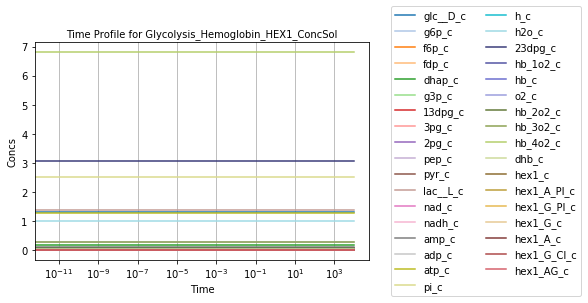

In [30]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis_hb_HEX1)
options={'method': 'LSODA', 'atol': 1e-15}
sim.find_steady_state_model(model=glycolysis_hb_HEX1, strategy="simulate",
                            update_initial_conditions=True, 
                            update_reactions=True, **options)

t0, tf = (0, 1e4)
conc_sol, flux_sol = sim.simulate_model(glycolysis_hb_HEX1, time=(t0, tf), **options)
conc_sol.preview_time_profile

### Storing information and references
#### Compartment
Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the <font color=#4682B4>EnzymeModule</font><font color=#1E90FF>.compartments</font> attribute.

In [31]:
HEX1.compartments = {"c": "Cytosol"}
print(HEX1.compartments)

{'c': 'Cytosol'}


#### Units
All of the units for the numerical values used in this model are "Millimoles" for amount and "Liters" for volume (giving a concentration unit of 'Millimolar'), and "Hours" for time. In order to ensure that future users understand the numerical values for model, it is important to define the <font color=#4682B4>EnzymeModule</font><font color=#1E90FF>.units</font> attribute.

The <font color=#4682B4>EnzymeModule</font><font color=#1E90FF>.units</font> is a <font color=#008000>cobra</font><font color=#556B2F>.DictList</font> that contains only <font color=#4682B4>UnitDefinition</font> objects from the <font color=#0000FF>mass.core.unit</font> submodule. 

Each <font color=#4682B4>UnitDefinition</font> is created from <font color=#4682B4>Unit</font> objects representing the base units that comprise the <font color=#4682B4>UnitDefinition</font>. These <font color=#4682B4>Units</font> are stored in the <font color=#1E90FF>list_of_units</font> attribute. Pre-built units can be viewed using the <font color=#00008B>print_defined_unit_values</font> function from the <font color=#0000FF>mass.core.unit</font></td> submodule. Alternatively, custom units can also be created using the <font color=#4682B4>UnitDefinition</font><font color=#00008B>.create_unit</font> function.

For more information about units, please see the module docstring for <font color=#0000FF>mass.core.unit</font> submodule.

__Note:__ It is important to note that this attribute will NOT track units, but instead acts as a reference for the user and others so that they can perform necessary unit conversions.

In [32]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
HEX1.add_units([concentration, time])
print(HEX1.units)

[<UnitDefinition Millimolar "mM" at 0x125d5dba8>, <UnitDefinition hour "hr" at 0x125d5d128>]


## Export

After validation, the model is ready to be saved. The model can either be exported as a ".json" file or as an ".sbml" (".xml") file using their repsective submodules in <font color=#0000FF>mass.io</font></td>.

To export the model, only the path to the directory and the name of the model need to be specified. Both are shown below. 

In [33]:
filepath = path.realpath(path.join("models", HEX1.id))

### Export using JSON

In [34]:
json.save_json_model(mass_model=HEX1, filename=filepath + ".json")

### Export using SBML

In [35]:
sbml.write_sbml_model(mass_model=HEX1, filename=filepath + ".xml")

SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.


SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.


SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.


SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.


SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.


SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.


SBML user defined compounds must be in the form of a single capital letter followed by zero or more lowercase letters. Therefore removing all non-lowercase letters from the Moiety.
